Auteur : HOLY Amédée

Date : 15/04/2019

Cours : Data Mining

# Etude sur la santé financière des entreprises

* [Introduction](#Introduction)

    + [Contexte et objectifs](#Contexte-et-objectifs)
    
    + [Requirements](#Requirements)

* [Datasets](#Datasets)

    + [Description des données](#Description-des-données)
    
    + [Données de validation](#Données-de-validation)
    
* [Les grandes etapes du projet](#Les-grandes-etapes-du-projet)


* [Importation des données](#Importation-des-données)

* [Gestion des données manquantes et données de validation](#Gestion-des-données-manquantes-et-données-de-validation)
    
    + [Données manquantes](#Données-manquantes)
    
    + [Définition des données de validation](#Définition-des-données-de-validation)
    
* [Gradient Boost (GBM)](#Gradient-Boost-(GBM))

    + [La sélection des features](#La-sélection-des-features)
    
    + [Choix du modèle](#Choix-du-modèle)
 
* [XGB](#XGB)

    + [Sélection des features](#Sélection-des-features)
    
    + [Choix du modèle](#Choix-du-modèle)
    
* [Optimisation des paramètres de XGB](#Optimisation-des-paramètres-de-XGB)

* [Faire tourner le modèle optimal sur l'ensemble des données](#Faire-tourner-le-modèle-optimal-sur-l'ensemble-des-données)
* [Modèle final](#Modèle-final)

## Introduction

### Contexte et objectifs

Pour le projet Data Mining, J'ai choisi d'explorer les données issue du Kaggle DAD Bankruptcy prediction challenge 2019  accessible à [cette adresse](https://www.kaggle.com/c/dad-bankruptcy-prediction-challenge-2019).

L’objectif du Kaggle est de predire la santé financière des entreprises françaises  à partir de leurs données financières de 2013 et 2014, en utilisant des données étiquetées de sociétés similaires de 2011 à 2013..

### Requirements

Les requirements pour le projets sont listés ci-dessous

In [7]:
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns
import copy
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import f1_score, fbeta_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import functools
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
plt.style.use('ggplot') #Used to give a pretty look to our plots

## Datasets

### Description des données

Les données mises à la disposition des competiteurs sont les suivantes :

 X_train.csv : Ce fichier CSV contient les données des entreprises françaises de 2011 à 2013 repartis sur 50 colonnes. Les 51 colonnes etant les caracteristiques financières d'une entreprise.

y_train.csv : Ce fichier contient la santé financière des entreprises avec les caracteristiques presentent dans le fichier X_train.csv. Elle contient des 0 et des 1, 1 etant que l'entreprise a fait faillite et 0, l'entreprise en bonne santé.

X_test.csv : Ce dernier fichier contient les caracteristiques financières des années 2013 et 2014 de d'autres enteprises françaises.

Un fichier VariablesDetails.pdf listes les differentes variables utilisés pour les données citées ci-dessus

### Données de validation

L'objectif premier de ce Kaggle est de trouver une methode, un algorithme de prediction efficace pour minimiser au mieux l'erreur de generalisation. 
J'ai donc besoin d'un dataset de validation vu que je serai améné à essayer pas mal de méthode de classification vu au cours.

Je definis comme données de validation les données du X_train et du y_train pour lesquels l'année est 2013. La validation se fera donc sur les données de l'année 2013

## Les grandes etapes du projet

Les fichiers fournis presentent une bonne part de données manquantes et dans un premier temps je vais essayer de pallier à ce problème avec l'une des techniques vu au cours.

La deuxième partie sera consacré à la selection de features importantes afin de manimiser au mieux l'erreur de generalisation

La troisièmes partie sera quant à elle dediée à la recherche de paramètre optimal pour notre algorithme de prédiction

En resumé le projet est construit autour de trois grandes parties ci-dessous

###### Gestion des données manquantes
###### Selection des features importantes pour chaque classifieur et evaluation du classifieur
###### Optimisation des paramètres du modèle choisi 

## Importation des données

In [8]:
names=["x"+str(i+1) for i in range(50)]
names.append("date")
raw_X_train_df=pd.read_csv("data/X_train.csv", delim_whitespace=True, names=names)
raw_y_train_df=pd.read_csv("data/y_train.csv", names=["labels"]).astype('int64')
raw_X_test_df=pd.read_csv("data/X_test.csv", delim_whitespace=True, names=names)
raw_X_train_df.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x42,x43,x44,x45,x46,x47,x48,x49,x50,date
0,1.41474,-6.32504,1.21334,2.46315,0.08513,1.66898,0.96788,4.47367,-1.01270,0.42254,...,-0.78340,-0.00270,0.49433,0.33872,4.67084,-0.69444,-3.72166,-1.09392,-0.91870,2013.0
1,-0.74624,-0.63700,-0.10950,-0.13609,-0.89492,-1.47830,0.01945,2.28490,-0.73309,-0.84357,...,-0.44426,-0.66274,-0.41219,3.25904,-0.79008,-0.52844,-2.06497,-0.03530,-0.51843,2011.0
2,NaN,NaN,0.34646,1.35668,0.16171,1.10147,0.06753,-0.64725,-0.74869,0.07595,...,5.85769,0.17108,0.02600,0.48129,-0.31450,0.59264,0.22557,-0.32838,-3.45497,2012.0
3,-0.85321,-0.74950,-0.02207,-0.04704,-1.41795,-1.11136,-0.69715,-0.83827,1.01270,1.06966,...,1.32692,1.49828,0.34232,-0.80219,-0.10392,-0.69444,0.16473,-0.90961,0.22027,2013.0
4,0.80435,2.36378,0.40421,0.28992,0.60655,1.24382,-0.78606,-0.62053,0.26825,0.92153,...,-0.29338,-0.68124,-0.59200,-0.87734,1.71085,-0.69444,0.45842,-0.67864,0.15728,2012.0


In [4]:
# New cell added to adapt to the missing data in the train set
X_nan=raw_X_train_df.loc[raw_X_train_df['x1'].isin([np.nan])]
X_nan=X_nan.loc[X_nan['x2'].isin([np.nan])]

y_nan=raw_y_train_df.loc[raw_X_train_df['x1'].isin([np.nan])]
y_nan=y_nan.loc[X_nan['x2'].isin([np.nan])].values.ravel()

In [5]:
# New cell added to adapt to the missing data in the train set
New_X_train_df=raw_X_train_df.loc[~raw_X_train_df['x1'].isin([np.nan])]
New_X_train_df=New_X_train_df.loc[~New_X_train_df['x2'].isin([np.nan])]

New_y_train_df=raw_y_train_df.loc[~raw_X_train_df['x1'].isin([np.nan])]
New_y_train_df=New_y_train_df.loc[~New_X_train_df['x2'].isin([np.nan])]
New_y_train_df.shape, New_X_train_df.shape

((5308, 1), (5308, 51))

## Gestion des données manquantes et données de validation

### Données manquantes

In [6]:
# On test set
# a deep copy of raw_X_test_df
df_test=copy.deepcopy(raw_X_test_df)
NbrOfMissingValues=[]
for i in range(len(df_test)):
    NbrOfMissingValues.append(len(df_test.iloc[i,:])-df_test.iloc[i,:].count())
df_test['NbrOfMissingValues'] = pd.Series(NbrOfMissingValues, index=df_test.index)
# On train set 
# NbrOfMissingValuesT=[]
# for i in range(len(raw_X_train_df)):
#     NbrOfMissingValuesT.append(len(raw_X_train_df.iloc[i,:])-raw_X_train_df.iloc[i,:].count())
# raw_X_train_df['NbrOfMissingValues'] = pd.Series(NbrOfMissingValuesT, index=raw_X_train_df.index)

In [7]:
X=New_X_train_df.values[:,:50]
index_of_missings=list(df_test[df_test["NbrOfMissingValues"]!=0].index)
test_df=copy.deepcopy(df_test).iloc[:,:50]
X=New_X_train_df.values[:,:50]
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(X)
for Index in index_of_missings:
    test_df.iloc[Index,:]=test_df.iloc[Index,:].fillna(0)
    model_entry=test_df.iloc[Index,:].values.reshape(1,-1)
    indices_neighbors=neigh.kneighbors(model_entry,return_distance=False).ravel() 
    mean_vector=X[indices_neighbors,:].mean(axis=0)
    for i in range(len(test_df.iloc[Index,:])):
        if test_df.iloc[Index,i]==0:
            test_df.iloc[Index,i]=mean_vector[i]
            
# for missing in train too
for j in range(len(X_nan)):
    X_nan.iloc[j,:50]=X_nan.iloc[j,:50].fillna(0)
    Model_entry=X_nan.iloc[j,:50].values.reshape(1,-1)
    Indices_neighbors=neigh.kneighbors(Model_entry,return_distance=False).ravel() 
    Mean_vector=X[Indices_neighbors,:50].mean(axis=0)
    for i in range(len(X_nan.iloc[j,:50])):
        if X_nan.iloc[j,i]==0:
            X_nan.iloc[j,i]=Mean_vector[i]


In [8]:
X_train=New_X_train_df.values
y_train=New_y_train_df.values.ravel()
# X_nan=X_nan.values
X_test_adj=test_df.values

X_full_train, y_full_train=np.vstack((X_train, X_nan)), np.hstack((y_train, y_nan))

print("X_full_train shape is :", X_full_train.shape)
print("y_full_train shape is :", y_full_train.shape)
print("X_train shape is :", X_train.shape)
print("y_train shape is :", y_train.shape)
print("X_test shape is :", X_test_adj.shape)

X_full_train shape is : (8001, 51)
y_full_train shape is : (8001,)
X_train shape is : (5308, 51)
y_train shape is : (5308,)
X_test shape is : (4000, 50)


In [9]:
from collections import Counter
def bunkrupt_prcent(y):
    y_int=y.reshape(-1,)
    decom_y=Counter(y_int)
    return 100*(decom_y[1]/(decom_y[1]+decom_y[0]))
print("Percentage of bankcrupt companies in y_full_train  is {0}% and number is {1}".format(bunkrupt_prcent(y_full_train ),0.01*bunkrupt_prcent(y_full_train )*len(y_full_train)))
print("Percentage of bankcrupt companies in y_train is {0}% and number is {1}".format(bunkrupt_prcent(y_train),0.01*bunkrupt_prcent(y_train)*len(y_train)))
print("Percentage of bankcrupt companies in y_nan is {0}% and number is {1}".format(bunkrupt_prcent(y_nan),0.01*bunkrupt_prcent(y_nan)*len(y_nan)))

Percentage of bankcrupt companies in y_full_train  is 50.00624921884764% and number is 4001.0
Percentage of bankcrupt companies in y_train is 46.85380557648832% and number is 2487.0
Percentage of bankcrupt companies in y_nan is 56.219829186780544% and number is 1514.0


In [10]:
def SizeBankrupt(rate=0.60, neg_size=None):
    return int((1/((1/rate)-1))*neg_size)

def generate_sampled_train_data(X_train, y_train, rate=0.75):
    nbr_negative=dict(Counter(y_train.reshape(-1)))[0]
    n_samples=SizeBankrupt(rate=rate, neg_size=nbr_negative)
    X_train_neg, X_train_pos=copy.deepcopy(X_train[y_train==0]), copy.deepcopy(X_train[y_train==1])
    y_train_neg, y_train_pos=copy.deepcopy(y_train[y_train==0]), copy.deepcopy(y_train[y_train==1])
    res_indexes=resample(np.arange(X_train_pos.shape[0]), n_samples=n_samples)
    sampled_X_train_1, sampled_y_train_1 = X_train_pos[res_indexes], y_train_pos[res_indexes] 
    return np.vstack((sampled_X_train_1, X_train_neg)), np.hstack((sampled_y_train_1, y_train_neg))

 ### Définition des données de validation

In [11]:
X_full_train_2013, y_full_train_2013=copy.deepcopy(X_full_train[X_full_train[:,50]==2013]), copy.deepcopy(y_full_train[X_full_train[:,50]==2013])
x_validation, y_validation=X_full_train_2013[:,:50], y_full_train_2013
train, labels_train=copy.deepcopy(X_full_train[X_full_train[:,50]!=2013])[:,:50], copy.deepcopy(y_full_train[X_full_train[:,50]!=2013])

In [12]:
print("The percentage of 2013 (validation set) data on the whole set is : {0}%".format(100*X_full_train_2013.shape[0]/X_full_train.shape[0]))
print("Percentage of bankcrupt companies in y_validation is {0}% and number is {1}".format(bunkrupt_prcent(y_validation),0.01*bunkrupt_prcent(y_validation)*len(y_validation)))
print("Percentage of bankcrupt companies in labels_train is {0}% and number is {1}".format(bunkrupt_prcent(labels_train),0.01*bunkrupt_prcent(labels_train)*len(labels_train)))

The percentage of 2013 (validation set) data on the whole set is : 24.99687539057618%
Percentage of bankcrupt companies in y_validation is 50.0% and number is 1000.0
Percentage of bankcrupt companies in labels_train is 50.00833194467589% and number is 3001.0


In [13]:
# Compute ROC curve and ROC area for each class
def ROC_curve(y_test, y_score):
    plt.figure()
    lw=1
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], thresholds = roc_curve(y_test, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.legend()
    plt.show()
#########################################################################################################################

# X here - training set of examples
def get_oob_sample(rf, X):
    n_samples = X.shape[0]
    for tree in rf.estimators_:
        # Here at each iteration we obtain out of bag samples for every tree.
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
    return unsampled_indices

def compute_mean_CV(estimator, train, labels, k_folds=10):
    return cross_val_score(estimator, train, labels, cv=k_folds).mean()

def compute_mean_CV_F2(estimator, train, labels, scorer, k_folds=10):
    return cross_val_score(estimator, train, labels, cv=k_folds, scoring=scorer)

In [14]:
def important_feats(clf, clf_feats=range(50)):
    feature_importances = pd.DataFrame(clf.feature_importances_*100,index = raw_X_train_df.columns[clf_feats],columns=['importance']).sort_values('importance',ascending=False)
    df=feature_importances.cumsum()
    feat_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
    copy_feat_imp=copy.deepcopy(feat_imp)
    copy_feat_imp.index=copy_feat_imp.index+1
    plt.figure(figsize=(15,7))
    copy_feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return feat_imp

## Gradient Boost (GBM)

In [16]:
# typical example of sampling with replacement
train_sam, labels_train_sam=generate_sampled_train_data(train, labels_train, rate=0.95)
print("Percentage of bankcrupt companies in y_nan is {0}% and number is {1}".format(bunkrupt_prcent(labels_train_sam),0.01*bunkrupt_prcent(labels_train_sam)*len(labels_train_sam)))

Percentage of bankcrupt companies in y_nan is 95.0% and number is 57000.00000000001


### La sélection des features 

In [17]:
# scoring callable for f2_score
selected_features=range(50)

def f2Score(estimator, X, y, selected_features=range(50)):
    return fbeta_score(y_validation,estimator.predict(x_validation[:,selected_features]), beta=2)*100

Accuracy on training : 98.75015623047119 %
Mean CV accuracy : 99.46254681647939 %
Mean CV-F2-Val accuracy : 99.97599519903982 %

f2-score on validation set :  99.84025559105432 %
Accuracy on validation : 99.6 %
The confusion matrix for the validation set is :
  [[ 992    8]
 [   0 1000]]


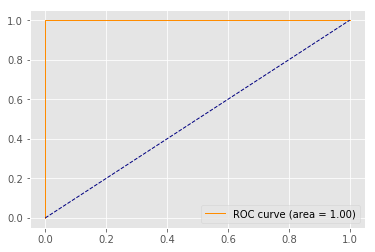

In [18]:
# GBM on the whole features
# On sampled train (95% of bankrupt)
all_clfGBC_weight=GradientBoostingClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)

sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=y_full_train, indices=None)
all_clfGBC_weight = all_clfGBC_weight.fit(X_full_train[:,selected_features], y_full_train, sample_weight=sample_weight)
 
print("Accuracy on training : "+str(100*(all_clfGBC_weight.score(X_full_train[:,selected_features], y_full_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(all_clfGBC_weight, X_full_train[:,selected_features], y_full_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(all_clfGBC_weight, X_full_train[:,selected_features], y_full_train,scorer=f2Score,k_folds=10))+" %")

# print("\nThe accuracy on the Out-of-bag samples is : {}%".format((clfGBC.oob_score_)*100))
# oob_samples=get_oob_sample(clfGBC, train_sam)
# X_out_bag,y_out_bag=  train_sam[oob_samples], labels_train_sam[oob_samples]
# print("f2-score on oob set : ", str(fbeta_score(y_out_bag,clfGBC.predict(X_out_bag), beta=2)*100)+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,all_clfGBC_weight.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(all_clfGBC_weight.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,all_clfGBC_weight.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, all_clfGBC_weight.predict_proba(x_validation[:,selected_features]))

print("\n\n\n")

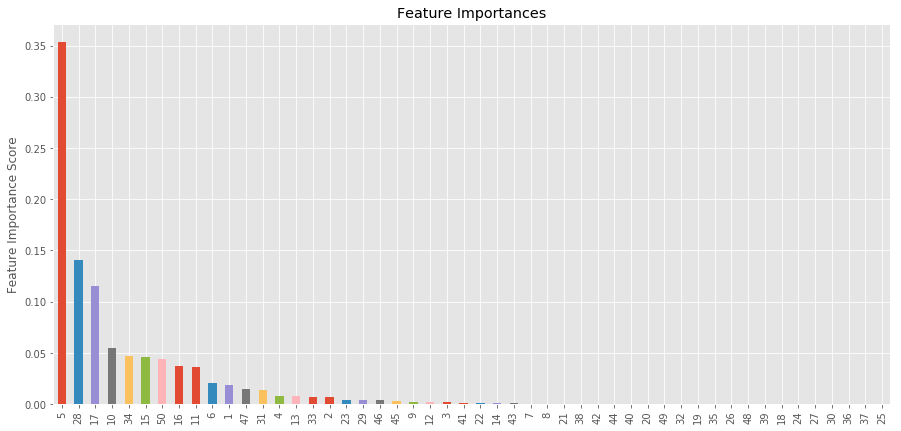

In [19]:
vars_iportances=important_feats(clf=all_clfGBC_weight, clf_feats=range(50)) 
a_clfGBC=vars_iportances.index

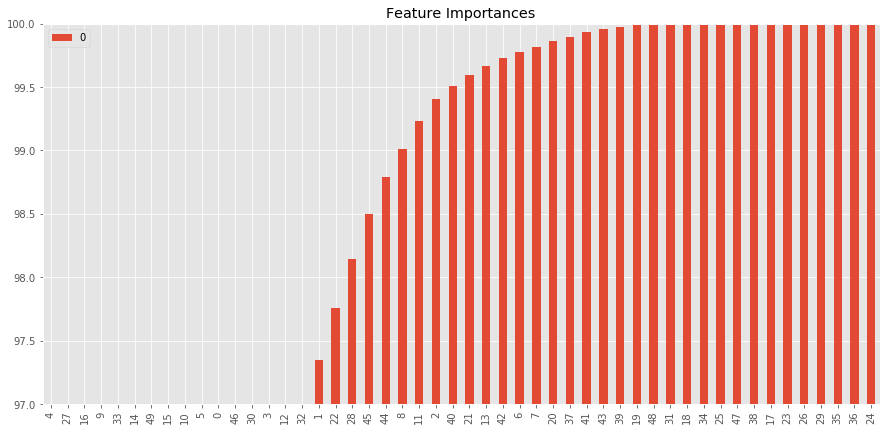

In [20]:
pd.DataFrame(100*np.cumsum(vars_iportances)).plot(kind='bar', title='Feature Importances', figsize=(15,7))
plt.ylim(97, 100) 
plt.show()

###  Choix du modèle

In [28]:
nbr_features=19
selected_features=a_clfGBC[:nbr_features]# select features
# selected_features=[8,3,0,1, 5, 6, 12, 19, 20, 24, 25, 26, 30, 35, 44, 33]
# def f2ScoreAd(estimator, X, y, selected_features=selected_features):
#     return fbeta_score(y,estimator.predict(X[:,selected_features]), beta=2)*100

def f2ScoreAd(estimator, X, y):
    return fbeta_score(y,estimator.predict(X), beta=2)*100


Accuracy on training : 98.36693884352607 %
Mean CV accuracy : 99.1667221297837 %
Mean CV-F2-Val accuracy : 99.28749296204822 %

f2-score on validation set :  96.681240063593 %
Accuracy on validation : 95.7 %
The confusion matrix for the validation set is :
  [[941  59]
 [ 27 973]]


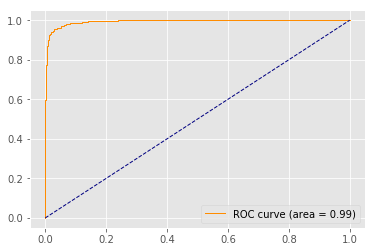

In [29]:
# Train on partial train and validate on validation set
# selected_features=[8,3,0,1, 5, 6, 12, 19, 20, 24, 25, 26, 30, 35, 44, 33]

clfGBC_weight=GradientBoostingClassifier(criterion='friedman_mse', init=None,
                  learning_rate=0.1, loss='deviance', max_depth=3,
                  max_features=None, max_leaf_nodes=None,
                  min_impurity_decrease=0.0, min_impurity_split=None,
                  min_samples_leaf=105, min_samples_split=50,
                  min_weight_fraction_leaf=0.0, n_estimators=90,
                  n_iter_no_change=None, presort='auto', random_state=None, tol=0.0001, validation_fraction=0.1,
                  verbose=0)

sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)
clfGBC_weight = clfGBC_weight.fit(train[:,selected_features], labels_train, sample_weight=sample_weight)
 
print("Accuracy on training : "+str(100*(clfGBC_weight.score(train[:,selected_features], labels_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(clfGBC_weight, train[:,selected_features], labels_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(clfGBC_weight, train[:,selected_features], labels_train,scorer=f2ScoreAd,k_folds=10))+" %")

# print("\nThe accuracy on the Out-of-bag samples is : {}%".format((clfGBC.oob_score_)*100))
# oob_samples=get_oob_sample(clfGBC, train_sam)
# X_out_bag,y_out_bag=  train_sam[oob_samples], labels_train_sam[oob_samples]
# print("f2-score on oob set : ", str(fbeta_score(y_out_bag,clfGBC.predict(X_out_bag), beta=2)*100)+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,clfGBC_weight.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(clfGBC_weight.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,clfGBC_weight.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, clfGBC_weight.predict_proba(x_validation[:,selected_features]))

print("\n\n\n")

## XGB

[0.0892587  0.02874433 0.08623298 0.04236006 0.06959153 0.05295008
 0.0075643  0.05597579 0.0741301  0.00907716 0.03025719 0.00605144
 0.06354009 0.04538578 0.00453858 0.00302572 0.00605144 0.01210287
 0.02118003 0.01664145 0.02874433 0.02269289 0.01210287 0.02571861
 0.02571861 0.03177005 0.02269289 0.         0.         0.00605144
 0.01210287 0.0075643  0.         0.02723147 0.00302572 0.00453858
 0.01815431 0.         0.         0.00302572 0.         0.00907716
 0.         0.00907716 0.00302572 0.         0.00302572 0.
 0.         0.        ]


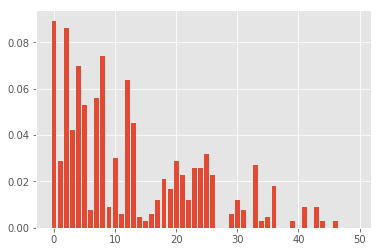

In [30]:
# plot feature importance manually
selected_features=a_clfGBC[:50]# select features


model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
# 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=y_full_train, indices=None)
model.fit(X_full_train[:,selected_features], y_full_train, sample_weight=sample_weight)
# feature importance
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

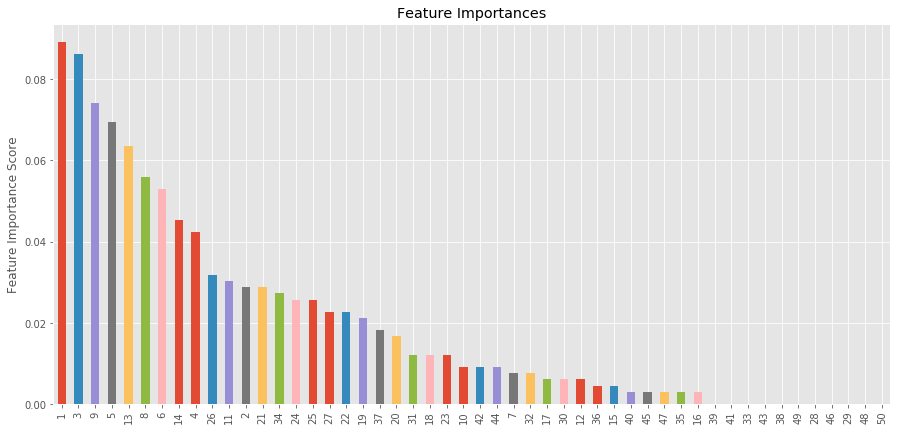

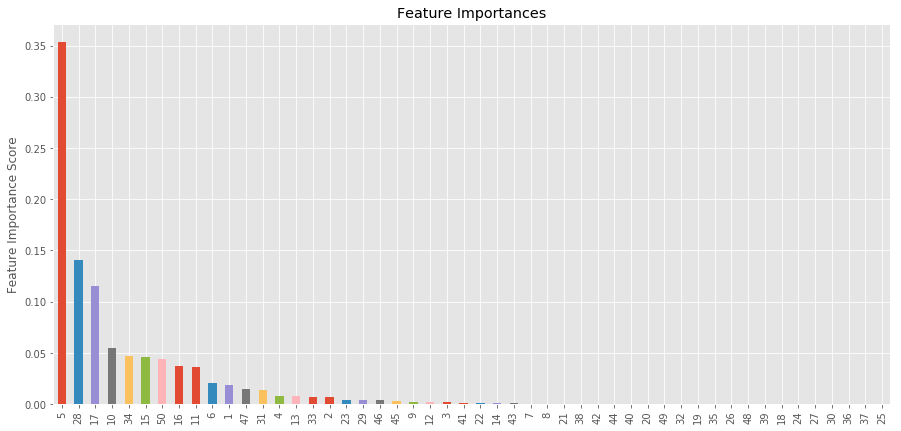

In [31]:
vars_iportances_xgb=important_feats(clf=model, clf_feats=a_clfGBC[:50]) 
vars_iportances=important_feats(clf=all_clfGBC_weight, clf_feats=range(50)) 
a_xgb=vars_iportances_xgb.index
# [43, 17,15,16,47,9,14]

In [ ]:
# Liquidity		
# x1		(Cash+Mark.Sec)/Current Liabilities
# x2		(Cash+Mark.Sec)/Total Sales
# x3		Cash/Current Assets
# x4		Cash/Total Assets
# x5		Current Assets/Current Liabilities
# x6		Current Assets/Total Assets
# x7		Current Liabilities/Total Assets
# x8		Current Liabilities/Total Sales
# x9		Inventories/Total Assets
# x11		Quick Assets/Total Assets
# x12		Working Capital/Total Assets
# x13		Working Capital/Total Sales
# Solvency		
# x14		Financial Debt/Cash Flow
# Profitability		
# x20		Cash Flow/Total Assets
# x21		EBIT/Shareholder Funds
# x22		EBIT/Total Assets
# x23		EBITDA/Permanent Equity
# x24		EBITDA/Total Assets
# x25		Net Income/Shareholder Funds
# x26		Net Income/Total Assets
# Financial Structure		
# x28		Long Term Debt/Shareholder Funds
# x30		Net Op.Work.Capital/Total Assets
# x31		Shareholder Funds/Permanent Equity
# x32		Shareholder Funds/Total Assets
# x34		Total Debt/Total Assets
# Activity		
# x37		EBIT/Value Added
# x43		Value Added/Total Assets
# Turnover		
# x45		Accounts Payable/Total Sales

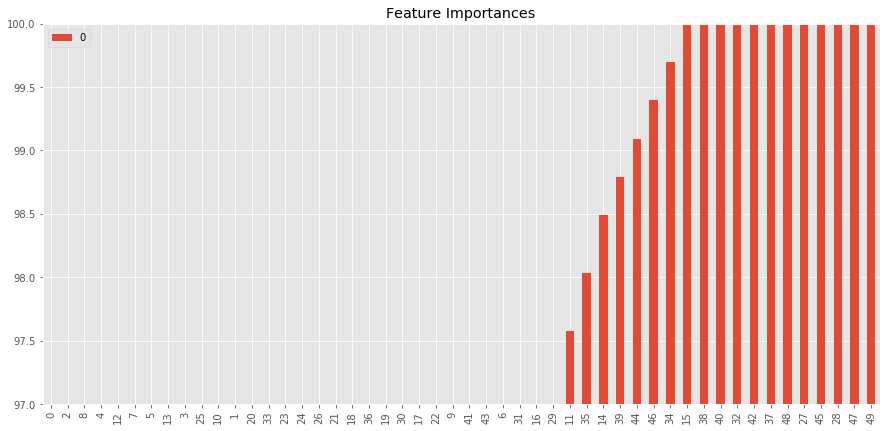

In [32]:
pd.DataFrame(100*np.cumsum(vars_iportances_xgb)).plot(kind='bar', title='Feature Importances', figsize=(15,7))
plt.ylim(97, 100) 
plt.show()

In [33]:
print(selected_features)

Int64Index([ 4, 27, 16,  9, 33, 14, 49, 15, 10,  5,  0, 46, 30,  3, 12, 32,  1,
            22, 28, 45, 44,  8, 11,  2, 40, 21, 13, 42,  6,  7, 20, 37, 41, 43,
            39, 19, 48, 31, 18, 34, 25, 47, 38, 17, 23, 26, 29, 35, 36, 24],
           dtype='int64')


Accuracy on training : 97.70038326945509 %
Mean CV accuracy : 99.2001663893511 %
Mean CV-F2-Val accuracy : 99.30070487087377 %

f2-score on validation set :  97.11106773374976 %
Accuracy on validation : 93.35 %
The confusion matrix for the validation set is :
  [[872 128]
 [  5 995]]


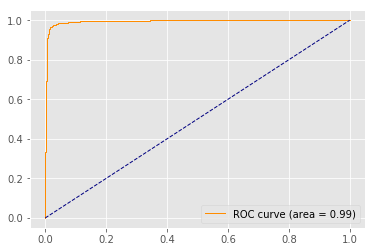

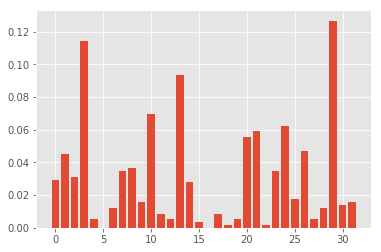

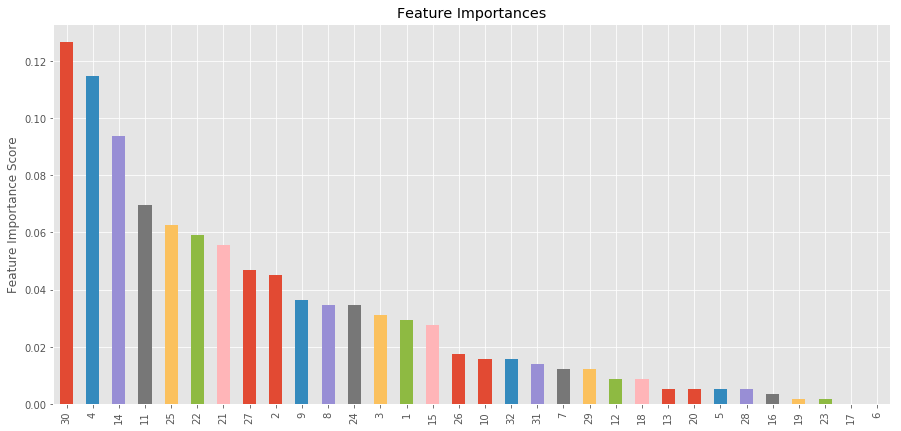

In [35]:
# plot feature importance manually
nbr_features=32
selected_features=a_xgb[:nbr_features]
# f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
f2ScoreAd_partial = functools.partial(f2ScoreAd)

XGB_tr = XGBClassifier(criterion='friedman_mse',
                  learning_rate=0.1, loss='deviance', max_depth=3,
                  min_impurity_decrease=0.0, 
                  min_samples_leaf=105, min_samples_split=50,
                  min_weight_fraction_leaf=0.0, n_estimators=90,
                  presort='auto', tol=0.0001, validation_fraction=0.1,
                  verbose=0, n_jobs=2)
# 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)
XGB_tr.fit(train[:,selected_features], labels_train, sample_weight=sample_weight)

print("Accuracy on training : "+str(100*(XGB_tr.score(train[:,selected_features], labels_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr, train[:,selected_features], labels_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr, train[:,selected_features], labels_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

# print("\nThe accuracy on the Out-of-bag samples is : {}%".format((clfGBC.oob_score_)*100))
# oob_samples=get_oob_sample(clfGBC, train_sam)
# X_out_bag,y_out_bag=  train_sam[oob_samples], labels_train_sam[oob_samples]
# print("f2-score on oob set : ", str(fbeta_score(y_out_bag,clfGBC.predict(X_out_bag), beta=2)*100)+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(XGB_tr.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, XGB_tr.predict_proba(x_validation[:,selected_features]))

print("\n\n\n")

# feature importance
plt.bar(range(len(XGB_tr.feature_importances_)), XGB_tr.feature_importances_)
vars_iportances_xgb=important_feats(clf=XGB_tr, clf_feats=selected_features) 
plt.show()

Accuracy on training : 97.78777652793401 %
Mean CV accuracy : 99.15012484394505 %
Mean CV-F2-Val accuracy : 99.22559854775383 %

f2-score on validation set :  99.60159362549798 %
Accuracy on validation : 99.0 %
The confusion matrix for the validation set is :
  [[ 980   20]
 [   0 1000]]


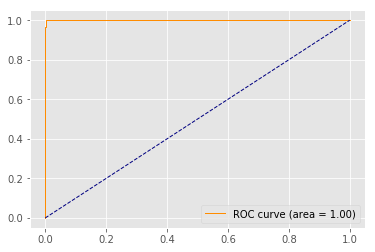

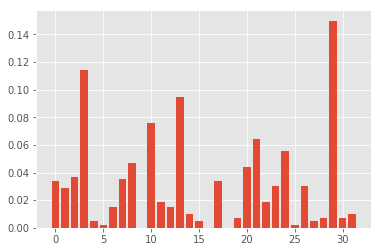

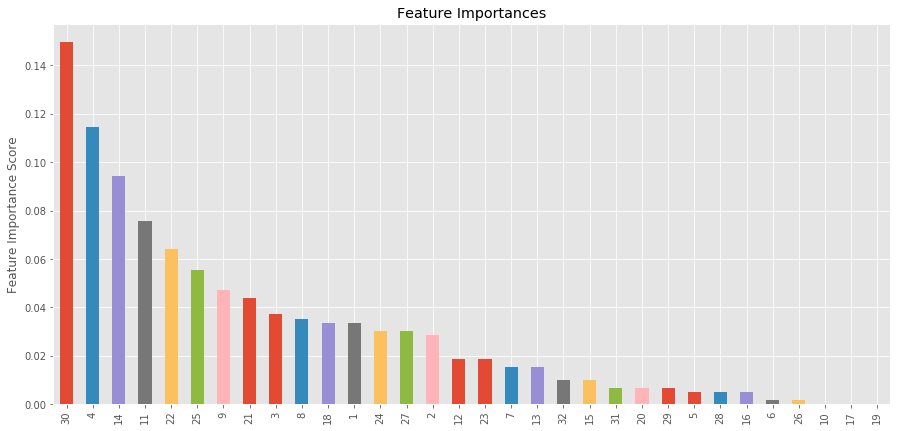

In [37]:
# plot feature importance manually
from xgboost import XGBClassifier
import functools
nbr_features=32
selected_features=a_xgb[:nbr_features]
# f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
f2ScoreAd_partial = functools.partial(f2ScoreAd)

XGB_tr_all_data = XGBClassifier(criterion='friedman_mse',
                  learning_rate=0.1, loss='deviance', max_depth=3,
                  min_impurity_decrease=0.0, 
                  min_samples_leaf=105, min_samples_split=50,
                  min_weight_fraction_leaf=0.0, n_estimators=90,
                  presort='auto', tol=0.0001, validation_fraction=0.1,
                  verbose=0, n_jobs=2)
# 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=y_full_train, indices=None)
XGB_tr_all_data.fit(X_full_train[:,selected_features], y_full_train, sample_weight=sample_weight)

print("Accuracy on training : "+str(100*(XGB_tr_all_data.score(X_full_train[:,selected_features], y_full_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_all_data, X_full_train[:,selected_features], y_full_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_all_data, X_full_train[:,selected_features], y_full_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

# print("\nThe accuracy on the Out-of-bag samples is : {}%".format((clfGBC.oob_score_)*100))
# oob_samples=get_oob_sample(clfGBC, train_sam)
# X_out_bag,y_out_bag=  train_sam[oob_samples], labels_train_sam[oob_samples]
# print("f2-score on oob set : ", str(fbeta_score(y_out_bag,clfGBC.predict(X_out_bag), beta=2)*100)+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_all_data.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(XGB_tr_all_data.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_all_data.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, XGB_tr_all_data.predict_proba(x_validation[:,selected_features]))

print("\n\n\n")

# feature importance
plt.bar(range(len(XGB_tr_all_data.feature_importances_)), XGB_tr_all_data.feature_importances_)
vars_iportances_xgb=important_feats(clf=XGB_tr_all_data, clf_feats=selected_features) 
plt.show()

##### This is the best model so far for me with important features being 32 : 
[ 0,  2,  8,  4, 12,  7,  5, 13,  3, 24, 10, 19,  1, 33, 22, 23, 20,
            25, 17, 36, 18, 30, 29, 21, 42, 44,  9, 31,  6, 28, 16, 11]

##### Same model with drifting variables removed :

In [42]:
def remove_els(orig_list, drop_list):
    local_list=orig_list
    for el in drop_list:
        local_list.remove(el)
    return local_list
drop_list1=[16, 17, 9, 29, 19, 10]
drop_list2=[16, 17, 9, 29, 19]
drop_list3=[16, 17, 9, 29]
drop_lists=[drop_list1, drop_list2, drop_list3]

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 1, 20, 33, 23, 24, 26, 21, 18, 36, 30, 22, 41, 43, 6, 31, 11]
Accuracy on training : 94.85085819030161 %
Mean CV accuracy : 98.03380476982807 %
Mean CV-F2-Val accuracy : 98.07438085906414 %

f2-score on validation set :  94.07932554129145 %
Accuracy on validation : 87.25 %
The confusion matrix for the validation set is :
  [[763 237]
 [ 18 982]]


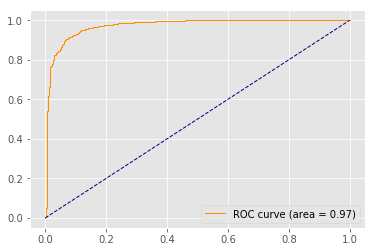





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 30, 22, 41, 43, 6, 31, 11]
Accuracy on training : 96.36727212131312 %
Mean CV accuracy : 98.46683305601775 %
Mean CV-F2-Val accuracy : 98.50768948210836 %

f2-score on validation set :  95.85037989479837 %
Accuracy on validation : 91.75 %
The confusion matrix for the validation set is :
  [[851 149]
 [ 16 984]]


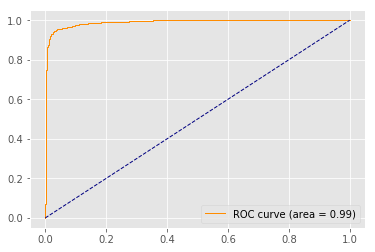





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11]
Accuracy on training : 96.86718880186635 %
Mean CV accuracy : 98.88355518580146 %
Mean CV-F2-Val accuracy : 98.99425036447724 %

f2-score on validation set :  95.83821805392732 %
Accuracy on validation : 92.2 %
The confusion matrix for the validation set is :
  [[863 137]
 [ 19 981]]


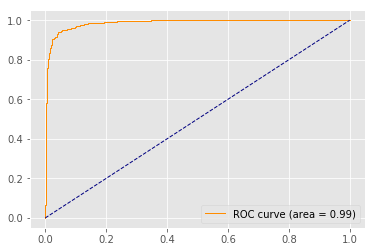

In [45]:
# plot feature importance manually
from xgboost import XGBClassifier
import functools
for dr_list in drop_lists:
    nbr_features=32
    selected_features=remove_els(list(a_xgb[:nbr_features]), dr_list)
    print("The selected features are : \n", selected_features)
#     f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
    f2ScoreAd_partial = functools.partial(f2ScoreAd)
    

    XGB_tr_drift = XGBClassifier(criterion='friedman_mse',
                      learning_rate=0.1, loss='deviance', max_depth=3,
                      min_impurity_decrease=0.0, 
                      min_samples_leaf=105, min_samples_split=50,
                      min_weight_fraction_leaf=0.0, n_estimators=90,
                      presort='auto', tol=0.0001, validation_fraction=0.1,
                      verbose=0, n_jobs=2)
    # 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
    sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)
    XGB_tr_drift.fit(train[:,selected_features], labels_train, sample_weight=sample_weight)

    print("Accuracy on training : "+str(100*(XGB_tr_drift.score(train[:,selected_features], labels_train)))+' %')
    print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_drift, train[:,selected_features], labels_train, k_folds=10))+" %")
    print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_drift, train[:,selected_features], labels_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

    print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_drift.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
    print("Accuracy on validation : "+str(100*(XGB_tr_drift.score(x_validation[:,selected_features], y_validation)))+' %')
    print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_drift.predict(x_validation[:,selected_features])))
    ROC_curve(y_validation, XGB_tr_drift.predict_proba(x_validation[:,selected_features]))

    print("\n\n\n")

##### Used model:

In [47]:
XGBClassifier()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [50]:
list(a_xgb[:nbr_features])

[0,
 2,
 8,
 4,
 12,
 7,
 5,
 13,
 3,
 25,
 10,
 1,
 20,
 33,
 23,
 24,
 26,
 21,
 18,
 36,
 19,
 30,
 17,
 22,
 9,
 41,
 43,
 6,
 31,
 16,
 29,
 11,
 35,
 14]

In [51]:
nbr_features=34 # best so far
# selected_features=remove_els_under_cdt(list(a_xgb[:nbr_features]), [43, 17,14,16,9])
selected_features=remove_els(list(a_xgb[:nbr_features]), [43, 17,14,16,9])

In [52]:
def f2ScoreAd_auc(estimator, X, y, selected_features, fall_alpha=0.7, f2_alpha=0.3):
    f2_val=fbeta_score(y_validation,estimator.predict(x_validation[:,selected_features]), beta=2)*100
#     aucc=roc_auc_score(y_validation,estimator.predict(x_validation[:,selected_features]))
    f2_all=compute_mean_CV_F2(estimator, X, y,scorer=f2ScoreAd,k_folds=5)
    return fall_alpha*f2_all+f2_alpha*f2_val

In [53]:
train[:, selected_features].shape
a_xgb[:nbr_features]

Int64Index([ 0,  2,  8,  4, 12,  7,  5, 13,  3, 25, 10,  1, 20, 33, 23, 24, 26,
            21, 18, 36, 19, 30, 17, 22,  9, 41, 43,  6, 31, 16, 29, 11, 35,
            14],
           dtype='int64')

## Optimisation des parmètres de XGB

In [54]:
#Tunin of estimator number (95% resampling case)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

f2ScoreAd_partial = functools.partial(f2ScoreAd_auc, selected_features=selected_features)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

# , min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test1, scoring=f2ScoreAd_partial,n_jobs=2,iid=False, cv=5)
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)

gsearch1.fit(train[:, selected_features],labels_train, sample_weight=sample_weight)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=2,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=functools.partial(<function f2ScoreAd_auc at 0x00000258A6617AE8>, selected_features=[0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 6, 31, 29, 11, 35]),
       verbose=0)

In [55]:
print(gsearch1.best_params_)
print("#################################################################")
print(gsearch1.best_score_)
print("#################################################################")
print(gsearch1.best_estimator_) 

{'max_depth': 7, 'min_child_weight': 1}
#################################################################
97.52059286857238
#################################################################
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)


In [56]:
#Tunin of estimator number (95% resampling case)
from sklearn.model_selection import GridSearchCV

f2ScoreAd_partial = functools.partial(f2ScoreAd_auc, selected_features=selected_features)

param_test2 = {
 'gamma':[i/10.0 for i in range(0,8)]
}

# , min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 subsample=0.8,
 max_depth=9,
 colsample_bytree=0.8,
 min_child_weight= 1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), param_grid = param_test2, scoring=f2ScoreAd_partial,n_jobs=2,iid=False, cv=5)
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)

gsearch2.fit(train[:, selected_features],labels_train, sample_weight=sample_weight)

print("#################################################################")
print(gsearch2.best_params_)
print("#################################################################")
print(gsearch2.best_score_)
print("#################################################################")
print(gsearch2.best_estimator_) 

#################################################################
{'gamma': 0.1}
#################################################################
97.58026842634084
#################################################################
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=9, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.8)


In [57]:
#Tunin of estimator number (95% resampling case)
from sklearn.model_selection import GridSearchCV

f2ScoreAd_partial = functools.partial(f2ScoreAd_auc, selected_features=selected_features)

param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

# , min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=9,
 min_child_weight= 1,
 objective= 'binary:logistic',
 nthread=4,
 gamma=0,
 scale_pos_weight=1,
 seed=27), param_grid = param_test3, scoring=f2ScoreAd_partial,n_jobs=2,iid=False, cv=5)
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)

gsearch3.fit(train[:, selected_features],labels_train, sample_weight=sample_weight)

print("#################################################################")
print(gsearch3.best_params_)
print("#################################################################")
print(gsearch3.best_score_)
print("#################################################################")
print(gsearch3.best_estimator_) 

#################################################################
{'colsample_bytree': 0.7, 'subsample': 0.7}
#################################################################
97.74519573356983
#################################################################
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.7)


In [58]:
#Tuning of estimator number (95% resampling case)
from sklearn.model_selection import GridSearchCV

f2ScoreAd_partial = functools.partial(f2ScoreAd_auc, selected_features=selected_features)

param_test4 = {
 'reg_alpha':[1e-5, 1e-4, 1e-3,1e-2],
'reg_lambda':[5e-5,1e-4, 1e-3]
}

# , min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
gsearch4 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
 n_estimators=100,
 max_depth=7,
 min_child_weight= 1,
 objective= 'binary:logistic',
 nthread=4,
 colsample_bytree = 0.6,
 subsample=0.7,
 gamma=0.1,
 scale_pos_weight=1,
 seed=27), param_grid = param_test4, scoring=f2ScoreAd_partial,n_jobs=2,iid=False, cv=5)
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)

gsearch4.fit(train[:, selected_features],labels_train, sample_weight=sample_weight)

print("#################################################################")
print(gsearch4.best_params_)
print("#################################################################")
print(gsearch4.best_score_)
print("#################################################################")
print(gsearch4.best_estimator_) 

#################################################################
{'reg_alpha': 0.0001, 'reg_lambda': 0.0001}
#################################################################
97.65903252315404
#################################################################
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.0001, reg_lambda=0.0001,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)


In [59]:
#Tunin of estimator number (95% resampling case)

f2ScoreAd_partial = functools.partial(f2ScoreAd_auc, selected_features=selected_features)

param_test5 = {
 'n_estimators':range(98,105,1)
}

# , min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
 reg_alpha=1e-3,
 reg_lambda=1e-3,                                                 
 max_depth=7,
 min_child_weight= 1,
 objective= 'binary:logistic',
 nthread=4,
 colsample_bytree = 0.6,
 subsample=0.7,
 gamma=0.1,
 scale_pos_weight=1,
 seed=27), param_grid = param_test5, scoring=f2ScoreAd_partial,n_jobs=2,iid=False, cv=5)
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)

gsearch5.fit(train[:, selected_features],labels_train, sample_weight=sample_weight)

print("#################################################################")
print(gsearch5.best_params_)
print("#################################################################")
print(gsearch5.best_score_)
print("#################################################################")
print(gsearch5.best_estimator_) 

#################################################################
{'n_estimators': 98}
#################################################################
97.61698028947634
#################################################################
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=98, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.001, reg_lambda=0.001,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)


The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 6, 31, 29, 11, 35, 14]
Accuracy on training : 99.0834860856524 %
Mean CV accuracy : 99.41669439822519 %
Mean CV-F2-Val accuracy : 99.50670967815009 %

f2-score on validation set :  98.18941504178271 %
Accuracy on validation : 97.39999999999999 %
The confusion matrix for the validation set is :
  [[961  39]
 [ 13 987]]


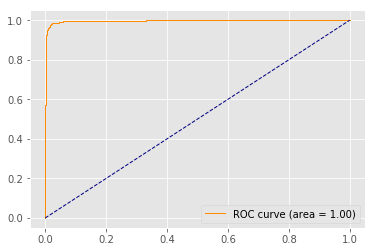

In [63]:
#Tunin of estimator number (95% resampling case)
selected_features=remove_els(list(a_xgb[:nbr_features]), [43, 17,16,9])

print("The selected features are : \n", selected_features)

# f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
f2ScoreAd_partial = functools.partial(f2ScoreAd)


XGB_tr_drift_tuned=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=103, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.001, reg_lambda=0.001,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.7)

sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)
XGB_tr_drift_tuned.fit(train[:,selected_features], labels_train, sample_weight=sample_weight)

print("Accuracy on training : "+str(100*(XGB_tr_drift_tuned.score(train[:,selected_features], labels_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_drift_tuned, train[:,selected_features], labels_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_drift_tuned, train[:,selected_features], labels_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_drift_tuned.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(XGB_tr_drift_tuned.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_drift_tuned.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, XGB_tr_drift_tuned.predict_proba(x_validation[:,selected_features]))

print("\n\n\n")

In [ ]:
# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11]
# Accuracy on training : 98.50024995834028 %
# Mean CV accuracy : 99.21677759290073 %
# Mean CV-F2-Val accuracy : 91.6906224356833 %
# f2-score on validation set :  97.02380952380953 %
# Accuracy on validation : 95.8 %
# The confusion matrix for the validation set is :
#   [[938  62]
#  [ 22 978]]

# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11, 14, 35]
# Accuracy on training : 98.23362772871188 %
# Mean CV accuracy : 99.16680532445923 %
# Mean CV-F2-Val accuracy : 93.93438324011173 %
# f2-score on validation set :  97.95958795562599 %
# Accuracy on validation : 96.5 %
# The confusion matrix for the validation set is :
#   [[941  59]
#  [ 11 989]]
# XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=9, min_child_weight=1, missing=None, n_estimators=95,
#        n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
#        reg_alpha=1e-05, reg_lambda=0.001, scale_pos_weight=1, seed=27,
#        silent=True, subsample=0.7)

# Wuth the new approach 50(F2train)/50(F2Val)
# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11, 14, 35]
# Accuracy on training : 99.25012497917014 %
# Mean CV accuracy : 99.38338879645038 %
# Mean CV-F2-Val accuracy : 99.45342073055517 %
# f2-score on validation set :  97.74586076201872 %
# Accuracy on validation : 97.35000000000001 %
# The confusion matrix for the validation set is :
#   [[967  33]
#  [ 20 980]]

# Wuth the new approach 70(F2train)/30(F2Val)
# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11, 14, 35]
# Accuracy on training : 99.26678886852191 %
# Mean CV accuracy : 99.40005546311704 %
# Mean CV-F2-Val accuracy : 99.46002972890604 %
# f2-score on validation set :  97.68509279584913 %
# Accuracy on validation : 97.35000000000001 %
# The confusion matrix for the validation set is :
#   [[968  32]
#  [ 21 979]]

# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 28, 11, 14, 35]
# Accuracy on training : 99.15014164305948 %
# Mean CV accuracy : 99.41669439822519 %
# Mean CV-F2-Val accuracy : 99.42667463774903 %
# f2-score on validation set :  98.18941504178271 %
# Accuracy on validation : 97.39999999999999 %
# The confusion matrix for the validation set is :
#   [[961  39]
#  [ 13 987]]

## Faire tourner le modèle optimal sur l'ensemble des données

In [64]:
#Tunin of estimator number (95% resampling case)
def tune_important_featuresNbr(nbr_features=32, ordered_imp_feats=a_xgb, drop_list=drop_lists[2]):
    selected_features=remove_els(list(a_xgb[:nbr_features]), drop_list)
        
    print("The selected features are : \n", selected_features)

#     f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
    f2ScoreAd_partial = functools.partial(f2ScoreAd)

    XGB_tr_drift_tuned = XGBClassifier(learning_rate=0.1,
     n_estimators=100,
     max_depth=3,
     min_child_weight= 1,
     objective= 'binary:logistic',
     nthread=4,
     colsample_bytree = 0.9,
     subsample=0.8,
     gamma=0,
     scale_pos_weight=1,
     reg_alpha=0, 
     reg_lambda=0.01,
     seed=27)

    sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=labels_train, indices=None)
    XGB_tr_drift_tuned.fit(train[:,selected_features], labels_train, sample_weight=sample_weight)

    print("Accuracy on training : "+str(100*(XGB_tr_drift_tuned.score(train[:,selected_features], labels_train)))+' %')
    print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_drift_tuned, train[:,selected_features], labels_train, k_folds=10))+" %")
    print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_drift_tuned, train[:,selected_features], labels_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

    print("f2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_drift_tuned.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
    print("Accuracy on validation : "+str(100*(XGB_tr_drift_tuned.score(x_validation[:,selected_features], y_validation)))+' %')
    print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_drift_tuned.predict(x_validation[:,selected_features])))
    ROC_curve(y_validation, XGB_tr_drift_tuned.predict_proba(x_validation[:,selected_features]))



The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11]
Accuracy on training : 97.71704715880686 %
Mean CV accuracy : 99.00019412090958 %
Mean CV-F2-Val accuracy : 99.04043774125574 %
f2-score on validation set :  95.79071597167585 %
Accuracy on validation : 93.2 %
The confusion matrix for the validation set is :
  [[890 110]
 [ 26 974]]


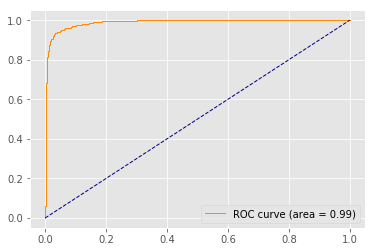

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35]
Accuracy on training : 97.88368605232462 %
Mean CV accuracy : 98.98352745424293 %
Mean CV-F2-Val accuracy : 99.03381906384499 %
f2-score on validation set :  96.2867864902232 %
Accuracy on validation : 94.35 %
The confusion matrix for the validation set is :
  [[912  88]
 [ 25 975]]


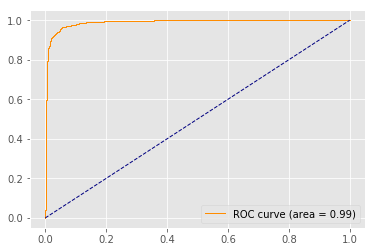

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14]
Accuracy on training : 98.01699716713881 %
Mean CV accuracy : 99.1334719911259 %
Mean CV-F2-Val accuracy : 99.19348497850305 %
f2-score on validation set :  97.19201107375916 %
Accuracy on validation : 95.45 %
The confusion matrix for the validation set is :
  [[926  74]
 [ 17 983]]


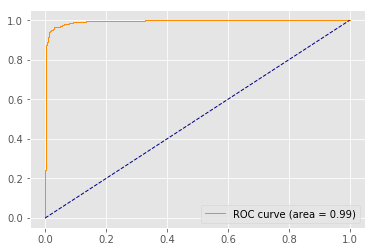

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14, 39]
Accuracy on training : 98.13364439260124 %
Mean CV accuracy : 99.06680532445924 %
Mean CV-F2-Val accuracy : 99.06649890374173 %
f2-score on validation set :  96.54832347140041 %
Accuracy on validation : 94.39999999999999 %
The confusion matrix for the validation set is :
  [[909  91]
 [ 21 979]]


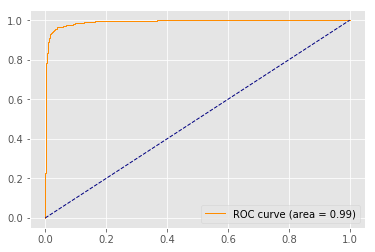

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14, 39, 44]
Accuracy on training : 98.28361939676721 %
Mean CV accuracy : 99.15016638935107 %
Mean CV-F2-Val accuracy : 99.15998425837785 %
f2-score on validation set :  96.6345207636292 %
Accuracy on validation : 94.15 %
The confusion matrix for the validation set is :
  [[901  99]
 [ 18 982]]


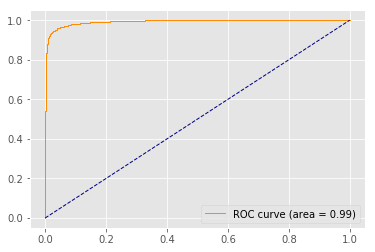

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14, 39, 44, 46]
Accuracy on training : 98.46692217963673 %
Mean CV accuracy : 99.26674986134219 %
Mean CV-F2-Val accuracy : 99.26672299018205 %
f2-score on validation set :  96.00158353127473 %
Accuracy on validation : 94.39999999999999 %
The confusion matrix for the validation set is :
  [[918  82]
 [ 30 970]]


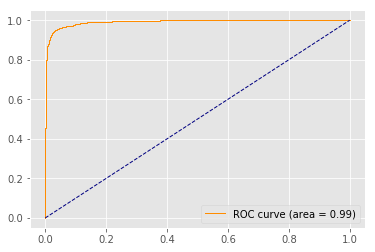

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14, 39, 44, 46, 34]
Accuracy on training : 98.31694717547076 %
Mean CV accuracy : 99.20011092623405 %
Mean CV-F2-Val accuracy : 99.15986456194784 %
f2-score on validation set :  96.00158353127473 %
Accuracy on validation : 94.39999999999999 %
The confusion matrix for the validation set is :
  [[918  82]
 [ 30 970]]


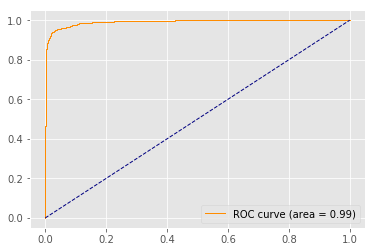

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 11, 35, 14, 39, 44, 46, 34, 15]
Accuracy on training : 98.56690551574737 %
Mean CV accuracy : 99.38338879645036 %
Mean CV-F2-Val accuracy : 99.43371862521731 %
f2-score on validation set :  95.69331788335263 %
Accuracy on validation : 90.2 %
The confusion matrix for the validation set is :
  [[813 187]
 [  9 991]]


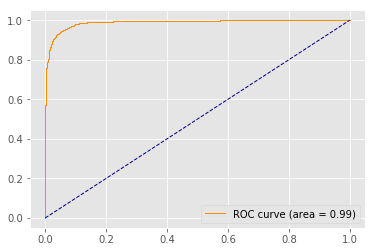

In [65]:
# outputs the performance of each set of important features
for k in range(32,40,1):
    tune_important_featuresNbr(nbr_features=k, ordered_imp_feats=a_xgb, drop_list=drop_lists[2])

### The best result is :  a_xgb[:39]
[0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11, 14, 35]

### - Train on the whole data :

In [67]:
# [43, 17,15,16,47,9,14]
# [16, 17, 9, 28]
def remove_els_under_cdt(orig_list, drop_list):
    local_list=orig_list
    for el in drop_list:
        if el in local_list:
            local_list.remove(el)
    return local_list
drop_lists_adj=[[16, 17, 9, 28],[43, 17,15],[43, 17,16],[43, 17,16,47],[43, 17,16,47,9],[43, 17,16,47,9,14]]

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 29, 11]
Accuracy on training : 99.27509061367329 %
Mean CV accuracy : 99.41259363295879 %
Mean CV-F2-Val accuracy : 99.42006164845932 %

f2-score on validation set :  99.94003597841295 %
Accuracy on validation : 99.85000000000001 %
The confusion matrix for the validation set is :
  [[ 997    3]
 [   0 1000]]


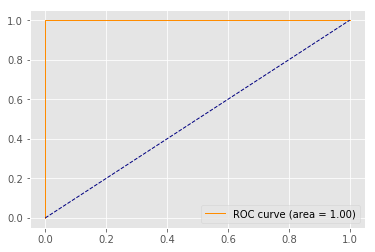





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 9, 41, 6, 31, 16, 29, 11]
Accuracy on training : 99.30008748906387 %
Mean CV accuracy : 99.43754681647941 %
Mean CV-F2-Val accuracy : 99.47519209193044 %

f2-score on validation set :  99.94003597841295 %
Accuracy on validation : 99.85000000000001 %
The confusion matrix for the validation set is :
  [[ 997    3]
 [   0 1000]]


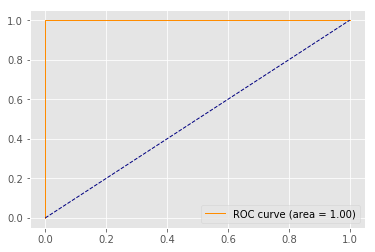





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 9, 41, 6, 31, 29, 11]
Accuracy on training : 99.36257967754031 %
Mean CV accuracy : 99.52506242197255 %
Mean CV-F2-Val accuracy : 99.47996208867986 %

f2-score on validation set :  99.86019572598363 %
Accuracy on validation : 99.65 %
The confusion matrix for the validation set is :
  [[ 993    7]
 [   0 1000]]


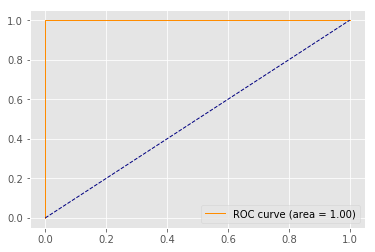





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 9, 41, 6, 31, 29, 11]
Accuracy on training : 99.36257967754031 %
Mean CV accuracy : 99.52506242197255 %
Mean CV-F2-Val accuracy : 99.47996208867986 %

f2-score on validation set :  99.86019572598363 %
Accuracy on validation : 99.65 %
The confusion matrix for the validation set is :
  [[ 993    7]
 [   0 1000]]


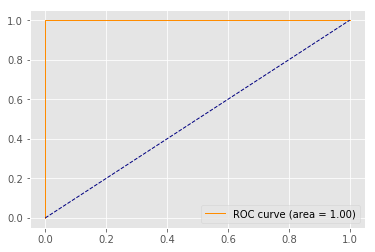





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 6, 31, 29, 11]
Accuracy on training : 99.33758280214973 %
Mean CV accuracy : 99.45006242197255 %
Mean CV-F2-Val accuracy : 99.38971674295718 %

f2-score on validation set :  99.94003597841295 %
Accuracy on validation : 99.85000000000001 %
The confusion matrix for the validation set is :
  [[ 997    3]
 [   0 1000]]


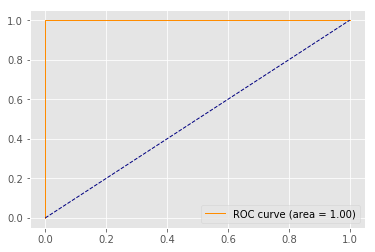





The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 6, 31, 29, 11]
Accuracy on training : 99.33758280214973 %
Mean CV accuracy : 99.45006242197255 %
Mean CV-F2-Val accuracy : 99.38971674295718 %

f2-score on validation set :  99.94003597841295 %
Accuracy on validation : 99.85000000000001 %
The confusion matrix for the validation set is :
  [[ 997    3]
 [   0 1000]]


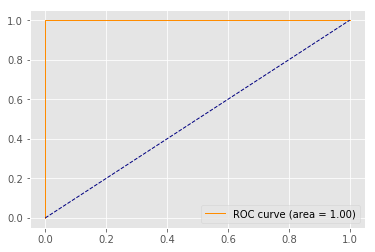

In [68]:
# plot feature importance manually
from xgboost import XGBClassifier
import functools
models, selcts_vars=[], []
for dr_list in drop_lists_adj:
    nbr_features=32
    selected_features=remove_els_under_cdt(list(a_xgb[:nbr_features]), dr_list)
    selcts_vars.append(selected_features)
    print("The selected features are : \n", selected_features)
#     f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)
    f2ScoreAd_partial = functools.partial(f2ScoreAd)

    XGB_tr_drift_all = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1e-05, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.9)
    # 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
    sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=y_full_train, indices=None)
    XGB_tr_drift_all.fit(X_full_train[:,selected_features], y_full_train, sample_weight=sample_weight)

    print("Accuracy on training : "+str(100*(XGB_tr_drift_all.score(X_full_train[:,selected_features], y_full_train)))+' %')
    print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_drift_all, X_full_train[:,selected_features], y_full_train, k_folds=10))+" %")
    print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_drift_all, X_full_train[:,selected_features], y_full_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

    print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_drift_all.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
    print("Accuracy on validation : "+str(100*(XGB_tr_drift_all.score(x_validation[:,selected_features], y_validation)))+' %')
    print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_drift_all.predict(x_validation[:,selected_features])))
    ROC_curve(y_validation, XGB_tr_drift_all.predict_proba(x_validation[:,selected_features]))
    models.append(XGB_tr_drift_all)
    print("\n\n\n")
    
#     Accuracy on training : 97.83777027871517 %
# Mean CV accuracy : 99.25007802746568 %
# Mean CV-F2-Val accuracy : 99.96399319447887 %

# f2-score on validation set :  99.64129135113589 %
# Accuracy on validation : 99.1 %
# The confusion matrix for the validation set is :
#   [[ 982   18]
#  [   0 1000]]

# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 28, 11]
# Accuracy on training : 99.36257967754031 %
# Mean CV accuracy : 99.50006242197254 %
# Mean CV-F2-Val accuracy : 99.51497660584366 %

# f2-score on validation set :  99.96001599360255 %
# Accuracy on validation : 99.9 %
# The confusion matrix for the validation set is :
#   [[ 998    2]
#  [   0 1000]]

- **With the tuned model :**

In [69]:
len(selected_features)

28

In [70]:
def f2ScoreAd(estimator, X, y, selected_features=selected_features):
    return fbeta_score(y,estimator.predict(X), beta=2)*100

The selected features are : 
 [0, 2, 8, 4, 12, 7, 5, 13, 3, 25, 10, 1, 20, 33, 23, 24, 26, 21, 18, 36, 19, 30, 22, 41, 43, 6, 31, 29, 11]
Accuracy on training : 99.27509061367329 %
Mean CV accuracy : 99.40009363295879 %
Mean CV-F2-Val accuracy : 99.40001909464989 %

f2-score on validation set :  99.94003597841295 %
Accuracy on validation : 99.85000000000001 %
The confusion matrix for the validation set is :
  [[ 997    3]
 [   0 1000]]


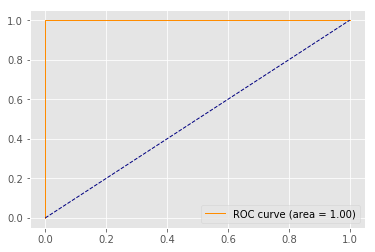

In [71]:
selected_features=remove_els_under_cdt(list(a_xgb[:nbr_features]), [16, 17, 9, 28])

print("The selected features are : \n", selected_features)

f2ScoreAd_partial = functools.partial(f2ScoreAd, selected_features=selected_features)

XGB_tr_drift_tuned_all = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
       n_estimators=101, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1e-05, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.9)

# 'max_depth=3', 'learning_rate=0.1', 'n_estimators=100', 'silent=True', "objective='binary:logistic'", "booster='gbtree'", 'n_jobs=1', 'nthread=None', 'gamma=0', 'min_child_weight=1', 'max_delta_step=0', 'subsample=1', 'colsample_bytree=1', 'colsample_bylevel=1', 'reg_alpha=0', 'reg_lambda=1', 'scale_pos_weight=1', 'base_score=0.5', 'random_state=0', 'seed=None', 'missing=None'
sample_weight=compute_sample_weight(class_weight={0: 0.05, 1:0.95}, y=y_full_train, indices=None)
XGB_tr_drift_tuned_all.fit(X_full_train[:,selected_features], y_full_train, sample_weight=sample_weight)

print("Accuracy on training : "+str(100*(XGB_tr_drift_tuned_all.score(X_full_train[:,selected_features], y_full_train)))+' %')
print("Mean CV accuracy : "+str(100*compute_mean_CV(XGB_tr_drift_tuned_all, X_full_train[:,selected_features], y_full_train, k_folds=10))+" %")
print("Mean CV-F2-Val accuracy : "+str(compute_mean_CV_F2(XGB_tr_drift_tuned_all, X_full_train[:,selected_features], y_full_train,scorer=f2ScoreAd_partial,k_folds=10))+" %")

print("\nf2-score on validation set : ", str(fbeta_score(y_validation,XGB_tr_drift_tuned_all.predict(x_validation[:,selected_features]), beta=2)*100)+" %")
print("Accuracy on validation : "+str(100*(XGB_tr_drift_tuned_all.score(x_validation[:,selected_features], y_validation)))+' %')
print("The confusion matrix for the validation set is :\n ", confusion_matrix(y_validation,XGB_tr_drift_tuned_all.predict(x_validation[:,selected_features])))
ROC_curve(y_validation, XGB_tr_drift_tuned_all.predict_proba(x_validation[:,selected_features]))
print("\n\n\n")

# New model with 34 features
# The selected features are : 
#  [0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11, 14, 35]
# Accuracy on training : 99.38757655293088 %
# Mean CV accuracy : 99.40004681647937 %
# Mean CV-F2-Val accuracy : 99.43007607786623 %
# f2-score on validation set :  99.96001599360255 %
# Accuracy on validation : 99.9 %
# The confusion matrix for the validation set is :
#   [[ 998    2]
#  [   0 1000]]

In [72]:
raw_X_train_df.iloc[:,[0, 2, 8, 4, 12, 7, 5, 13, 3, 24, 10, 19, 1, 33, 22, 23, 20, 25, 36, 18, 30, 29, 21, 42, 44, 31, 6, 11]].columns

Index(['x1', 'x3', 'x9', 'x5', 'x13', 'x8', 'x6', 'x14', 'x4', 'x25', 'x11',
       'x20', 'x2', 'x34', 'x23', 'x24', 'x21', 'x26', 'x37', 'x19', 'x31',
       'x30', 'x22', 'x43', 'x45', 'x32', 'x7', 'x12'],
      dtype='object')

In [ ]:
# Liquidity		
# x1		(Cash+Mark.Sec)/Current Liabilities
# x2		(Cash+Mark.Sec)/Total Sales
# x3		Cash/Current Assets
# x4		Cash/Total Assets
# x5		Current Assets/Current Liabilities
# x6		Current Assets/Total Assets
# x7		Current Liabilities/Total Assets
# x8		Current Liabilities/Total Sales
# x9		Inventories/Total Assets
# x11		Quick Assets/Total Assets
# x12		Working Capital/Total Assets
# x13		Working Capital/Total Sales
# Solvency		
# x14		Financial Debt/Cash Flow
# Profitability		
# x20		Cash Flow/Total Assets
# x21		EBIT/Shareholder Funds
# x22		EBIT/Total Assets
# x23		EBITDA/Permanent Equity
# x24		EBITDA/Total Assets
# x25		Net Income/Shareholder Funds
# x26		Net Income/Total Assets
# Financial Structure		
# x28		Long Term Debt/Shareholder Funds
# x30		Net Op.Work.Capital/Total Assets
# x31		Shareholder Funds/Permanent Equity
# x32		Shareholder Funds/Total Assets
# x34		Total Debt/Total Assets
# Activity		
# x37		EBIT/Value Added
# x43		Value Added/Total Assets
# Turnover		
# x45		Accounts Payable/Total Sales

# Modèle final

In [86]:

selected_features=remove_els_under_cdt(list(a_xgb[:nbr_features]), [16, 17, 9, 28])
X_test_adju=test_df.values# The X_test with KNN 
PredicionNbr25_95=XGB_tr_drift_tuned_all.predict(X_test_adju[:,selected_features])
The_PredicionNbr25_95=PredicionNbr25_95==1
pd.DataFrame(The_PredicionNbr25_95).to_csv("prediction_25.csv", header =["Expected"])
Counter(The_PredicionNbr25_95)
# Counter({True: 2287, False: 1713})

Counter({False: 1757, True: 2243})